In [1]:
# sudo service mysql stop
# docker run --name mysql -p 3306:3306 -e MYSQL_ROOT_PASSWORD=your_secret_pwd -d mysql:latest

In [1]:
import pymssql
import pymysql
import pandas as pd
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt

### connection init

In [2]:
# calls
with open('mysql_local.pass','r') as file:
    calls_pass = file.read().replace('\n', '')
    file.close()
calls_conn = pymysql.connect(
            host = '10.2.4.87', 
            user = 'root',
            passwd = calls_pass,
            db = '1c',
            autocommit = True
        )
calls_cursor = calls_conn.cursor()

In [3]:
# transcribations
with open('sql.pass','r') as file:
    trans_pass = file.read().replace('\n', '')
    file.close()            
trans_conn = pymssql.connect(
            server = '10.2.4.124',
            user = 'ICECORP\\1c_sql',
            password = trans_pass,
            database = 'voice_ai',
            #autocommit=True
        )
trans_cursor = trans_conn.cursor()

In [4]:
# mico96 (КЦ)
with open('mysql.pass','r') as file:
    mico_pass = file.read().replace('\n', '')
    file.close()
mico_conn = pymysql.connect(
            host = '10.2.4.146', 
            user = 'asterisk',
            passwd = mico_pass,
            db = 'MICO_96',
            #autocommit = True
        )
mico_cursor = mico_conn.cursor()

In [5]:
# mrm
with open('mysql.pass','r') as file:
    mico_pass = file.read().replace('\n', '')
    file.close()
mico_conn = pymysql.connect(
            host = '10.2.4.146', 
            user = 'asterisk',
            passwd = mico_pass,
            db = 'MICO_96',
            #autocommit = True
        )
mico_cursor = mico_conn.cursor()

### check mico96

In [ ]:
query = "show tables;"
tables = pd.read_sql(query, con = mico_conn)
tables

In [ ]:
query = "SELECT * from PT1C_cdr_MICO where calldate>'2021-04-26' limit 2;"
mico = pd.read_sql(query, con = mico_conn)
mico

In [ ]:
query = "SELECT calldate, src, dst, linkedid, peeraccount"
query += " from PT1C_cdr_MICO where calldate>'2021-04-26 12:05:00'"
#query += " and calldate<'2021-04-26 11:46:00'"
#query += " and peeraccount>'1619426331.30788'"
#query += " and linkedid>'1619426331.3078800'"
#query += " and linkedid<'1619426520.3078906'"
#query += " order by peeraccount limit 50;"
#" and not peeraccount = ''"
#query += " and linkedid ='1619426653.3078971'"
#query += " and peeraccount ='1619426653.3078971'"
#query += " and peeraccount ='1619425635.3078414'"
query += " order by calldate limit 50;"
mico = pd.read_sql(query, con = mico_conn)
mico

In [ ]:
# transcribations
query = "SELECT distinct top 50 record_date, src, dst, linkedid, source_id from transcribations"
query += " where record_date>='2021-04-26 12:05:00'"#" and source_id=2"
#query += " and linkedid>'1619426331.3078800'"
#query += " and linkedid<'1619426520.3078906'"
query += " order by record_date;"
#query += " order by linkedid;"
#query += " where record_date>='"+date_from+"' and linkedid = '1619424473.3077800';"
tr = pd.read_sql(query, con = trans_conn)
#tr[tr.linkedid=='1619424473.3077800']
tr

### report

In [6]:
def plot_grouped(df, header):
    
    df = df.drop(['base_name','_merge', 'call_date'], axis = 1)
    df = df.groupby(['day', 'ak', 'miko', 'mrm', 'incoming', 'outcoming']).count()
    # df.groupby('param')['group'].nunique()
    for i in range(6):
        df.reset_index(level=0, inplace=True)
    df.incoming *= df.linkedid
    df.outcoming *= df.linkedid
    df.mrm *= df.linkedid
    df.miko *= df.linkedid
    df.ak *= df.linkedid

    grp = []
    tmp = df[['day', 'incoming']].groupby('day').sum()
    tmp.reset_index(level=0, inplace=True)
    grp.append(tmp)
    tmp = df[['day', 'outcoming']].groupby('day').sum()
    tmp.reset_index(level=0, inplace=True)
    grp.append(tmp)
    tmp = df[['day', 'ak']].groupby('day').sum()
    tmp.reset_index(level=0, inplace=True)
    grp.append(tmp)
    tmp = df[['day', 'miko']].groupby('day').sum()
    tmp.reset_index(level=0, inplace=True)
    grp.append(tmp)
    tmp = df[['day', 'mrm']].groupby('day').sum()
    tmp.reset_index(level=0, inplace=True)
    grp.append(tmp)
    tmp = df[['day', 'linkedid']].groupby('day').sum()
    tmp.reset_index(level=0, inplace=True)
    grp.append(tmp)

    df = grp[0]
    for i in range(5):
        df = df.merge(grp[i+1], on='day', how='left')

    calls_max = df.linkedid.max()*3
    # Decide Colors 
    mycolors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:grey', 'red']

    # Draw Plot and Annotate
    fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
    columns = df.columns[1:6]
    labs = columns.values.tolist()

    # Prepare data
    x  = df['day'].values.tolist()
    y0 = df[columns[0]].values.tolist()
    y1 = df[columns[1]].values.tolist()
    y2 = df[columns[2]].values.tolist()
    y3 = df[columns[3]].values.tolist()
    y4 = df[columns[4]].values.tolist()
    y = np.vstack([y0, y1, y2, y3, y4])

    # Plot for each column
    labs = columns.values.tolist()
    ax = plt.gca()
    ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)

    # Decorations
    ax.set_title(header, fontsize=18)
    ax.set(ylim=[0, calls_max])
    ax.legend(fontsize=10, ncol=4)
    plt.xticks(x[::5], fontsize=10, horizontalalignment='center')
    plt.yticks(np.arange(calls_max, calls_max, calls_max/5), fontsize=10)
    plt.xlim(x[0], x[-1])

    # Lighten borders
    plt.gca().spines["top"].set_alpha(0)
    plt.gca().spines["bottom"].set_alpha(.3)
    plt.gca().spines["right"].set_alpha(0)
    plt.gca().spines["left"].set_alpha(.3)

    plt.show()

In [7]:
# calls
#query = "SELECT cast(call_date as date), ak, miko, mrm, incoming, linkedid, base_name from calls;"
query = "SELECT day(call_date) as day, date(call_date) as call_date, ak, miko, mrm, incoming, not incoming as outcoming, linkedid, base_name from calls;"
#query = "SELECT * from calls;"
calls = pd.read_sql(query, con = calls_conn)
date_min = calls.call_date.min()
date_max = calls.call_date.max()
#calls.drop(['id'], axis = 1, inplace = True)
calls

,day,call_date,ak,miko,mrm,incoming,outcoming,linkedid,base_name
0,22,2021-04-22,0,1,0,0,1,1619065299.3050508,1c_service_region
1,22,2021-04-22,1,0,1,0,1,1619065479.22323747,1c_service_region
2,22,2021-04-22,0,1,0,0,1,1619067128.3050609,1c_service_region
3,22,2021-04-22,0,1,0,0,1,1619067276.3050641,1c_service_region
4,22,2021-04-22,0,1,0,0,1,1619067872.3050737,1c_service_region
...,...,...,...,...,...,...,...,...,...
111440,3,2021-05-03,0,1,0,0,1,1620068320.3300350,1C_Service
111441,3,2021-05-03,0,1,0,1,0,1620069500.3300357,1C_Service
111442,3,2021-05-03,1,0,1,0,1,1620069668.104463,1C_Service
111443,3,2021-05-03,1,0,1,0,1,1620071927.104478,1C_Service


In [8]:
date_from = datetime.datetime.strptime(str(date_min), '%Y-%m-%d').strftime('%Y%m%d %H:%M:%S.000')
date_toto = datetime.datetime.strptime(str(date_max), '%Y-%m-%d').strftime('%Y%m%d %H:%M:%S.000')

In [9]:
# transcribations
#query = "SELECT distinct cast(record_date as date) as record_date, linkedid from transcribations"
query = "SELECT distinct linkedid from transcribations"
query += " where cast(record_date as date)>='"+date_from+"' and cast(record_date as date)<='"+date_toto+"';"
trans = pd.read_sql(query, con = trans_conn)
trans

,linkedid
0,1619266247.3048514
1,1619068752.2996436
2,1619284848.3055165
3,1619351855.3065124
4,1619496696.3161912
...,...
58058,1619768165.3238930
58059,1619071801.3052579
58060,1619616978.3131715
58061,1619761620.28053


In [10]:
date_min, date_max

(datetime.date(2021, 4, 22), datetime.date(2021, 5, 3))

In [11]:
len(calls), len(trans)

(111445, 58063)

In [12]:
df_all = pd.merge(calls, trans, on='linkedid', how="outer", indicator=True)

In [13]:
print('Звонков:', len(calls.linkedid.unique()))
print('Расшифровок:', len(trans.linkedid.unique()))
print('Связь установлена:', len(df_all[df_all._merge == 'both'].linkedid.unique()))
print('Идентификатор расшифровки не найден среди звонков:', len(df_all[df_all._merge == 'left_only'].linkedid.unique()))

Звонков: 67953
Расшифровок: 58063
Связь установлена: 26907
Идентификатор расшифровки не найден среди звонков: 41046


In [14]:
print(len(df_all[df_all._merge == 'left_only']), len(df_all[df_all._merge == 'right_only']))

84170 31156


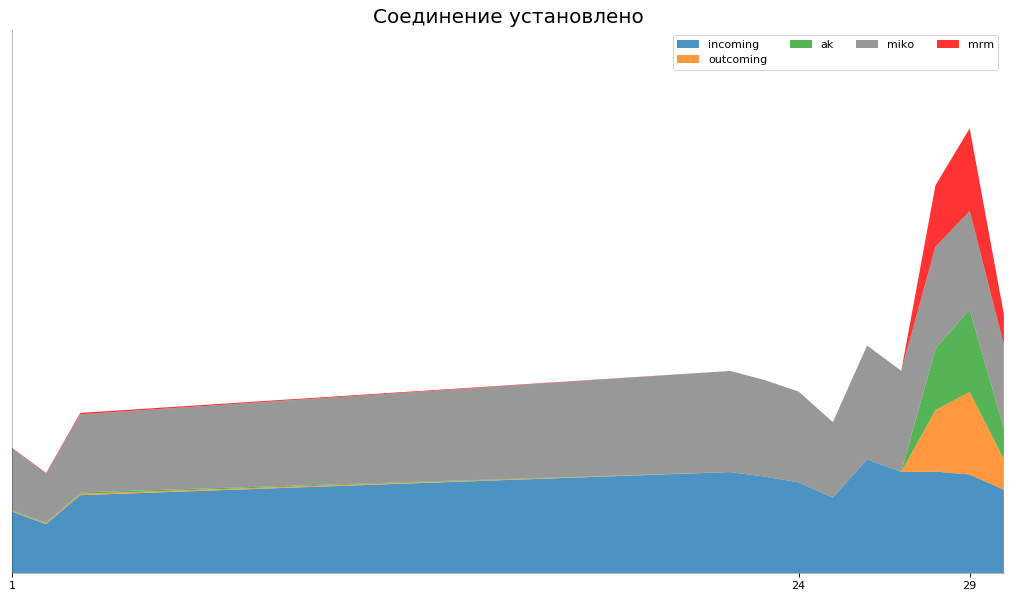

In [15]:
df = df_all[df_all._merge == 'both']
plot_grouped(df, 'Соединение установлено')

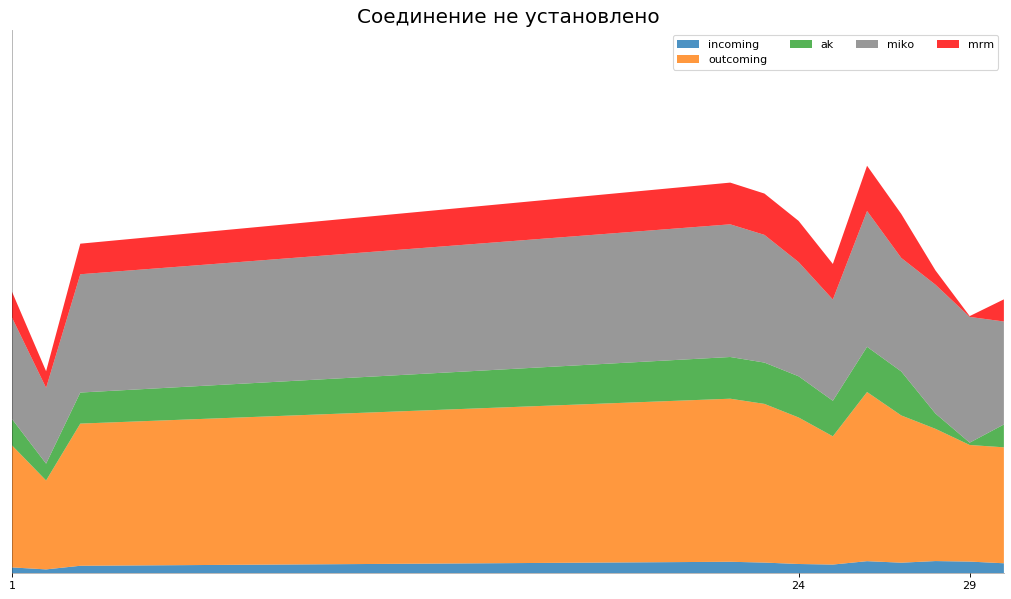

In [16]:
df = df_all[df_all._merge == 'left_only']
plot_grouped(df, 'Соединение не установлено')

In [44]:
df_all[((df_all._merge == 'both') & (df_all.mrm == True))]

,day,call_date,ak,miko,mrm,incoming,outcoming,linkedid,base_name,_merge


### database maintance

In [ ]:
query = "create database 1c;"
cursor.execute(query)

In [ ]:
query = "use 1c;"
cursor.execute(query)
for row in cursor.fetchall():
    print(row)

In [ ]:
query = "show tables;"
cursor.execute(query)
for row in cursor.fetchall():
    print(row)

In [ ]:
#--create table users ( id int not null auto_increment, token varchar(36), 
#email varchar(64), event_date DATETIME, primary key (id) );
query = "create table calls"
query += " ("
query += " id int not null auto_increment,"
query += " call_date DATETIME,"
query += " ak BOOLEAN,"
query += " miko BOOLEAN,"
query += " mrm BOOLEAN,"
query += " incoming BOOLEAN,"
query += " linkedid varchar(64),"
query += " base_name varchar(64),"
query += " primary key (id)"
query += " );"
cursor.execute(query)
for row in cursor.fetchall():
    print(row)

In [ ]:
# query = "drop table calls;"
# cursor.execute(query)
# for row in cursor.fetchall():
#     print(row)

In [ ]:
# query = "delete from calls;"
# cursor.execute(query)
# for row in cursor.fetchall():
#     print(row)

### experiments

In [ ]:
calls.linkedid = calls.linkedid.str.replace('.WAV','')

In [ ]:
calls[calls.linkedid=='1619120428.22353330.WAV']

In [ ]:
def get_base_name(val):
    return re.findall( r'"(.*?)"', val)[1]

In [ ]:
df.base_name = df.base_name.apply(get_base_name)

In [ ]:
df.base_name = df.base_name.str.replace(r'"(.*?)"', '')

In [ ]:
word = 'Srvr="msk-srv1c01" Ref="1c_service_region"'
re.findall( r'"(.*?)"', word)[1]

In [ ]:
re.findall( r'all (.*?) are', 'all cats are smarter than dogs, all dogs are dumber than cats')
# Output: ['cats', 'dogs']

[x.group() for x in re.finditer( r'all (.*?) are', 'all cats are smarter than dogs, all dogs are dumber than cats')]
# Output: ['all cats are', 'all dogs are']

In [ ]:
query = "SELECT column_name FROM information_schema.columns WHERE table_name='calls';"
calls = pd.read_sql(query, con = conn)
calls

In [ ]:
query = "SELECT column_name FROM information_schema.columns WHERE table_name='calls';"
calls = pd.read_sql(query, con = conn)
calls

In [ ]:
filename = 'data.csv'
dateparser = lambda x: datetime.datetime.strptime(x, "%d.%m.%Y %H:%M:%S")
dtypes = {
        'call_date': 'datetime64',
        'ak': 'bool',
        'miko': 'bool',
         'mrm': 'bool',
         'incoming': 'bool',
         'linkedid': 'str',
         'base_name': 'str',
     }
#df = pd.read_csv(filename, ';', dtype=dtypes, parse_dates = True)
#df = pd.read_csv(filename, ';', parse_dates = True)
df = pd.read_csv(filename, ';', parse_dates = ['call_date'], date_parser=dateparser)
df.call_date.iloc[0], type(df.call_date.iloc[0])

In [ ]:
df.base_name.iloc[0], type(df.base_name.iloc[0])

In [51]:
# search for call
query = "SELECT distinct src, dst, linkedid, record_date, duration from transcribations"
#query = "SELECT linkedid, record_date, start, text from transcribations"
#query += " where record_date>'2021.04.26 08:00:00' and record_date<'2021.04.26 08:10:00'"
query += " where record_date='2021-04-26 08:00:24'"
query += " order by record_date;"
columns = pd.read_sql(query, con = trans_conn)
columns

,src,dst,linkedid,record_date,duration
0,5076,89661206965,1619413224.3071862,2021-04-26 08:00:24,0.0


In [ ]:
# search for call
query = "SELECT linkedid, text from transcribations"
query += " where record_date>'2021.04.26 00:00:00' and record_date<'2021.04.27 00:00:00'"
query += " group by linkedid, text;"
columns = pd.read_sql(query, con = trans_conn)
columns

In [36]:
query = "SELECT column_name FROM information_schema.columns WHERE table_name='transcribations';"
columns = pd.read_sql(query, con = trans_conn)
columns

,column_name
0,transcribation_date
1,date_y
2,date_m
3,date_d
4,side
5,text
6,start
7,audio_file_name
8,conf
9,end_time
